In [2]:
%pip install --upgrade langchain-groq sentencepiece langchain_huggingface langchain-huggingface text-generation transformers google-search-results numexpr langchainhub sentencepiece jinja2 bitsandbytes langchain-core langchain-anthropic accelerate

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 924.6 kB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 405.0/405.0 KB 649.7 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 641.0 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 1.5 MB/s eta 0:00:0000:0100:04
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 KB 673.3 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 436.4/436.4 KB 688.8 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 648.5 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 KB 836.4 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 435.0/435.0 KB 756.8 kB/s eta 0:00:00a 0:00:

In [1]:
# get the code for loading API keys using .env file
from dotenv import load_dotenv
import os

# Load the environment variables from the .env file
load_dotenv()

# Access environment variables
HUGGINGFACE_API_KEY = os.getenv('LANGCHAIN_API_KEY')
TAVILY_API_KEY = os.getenv('TAVILY_API_KEY')
GROQ_API_KEY = os.getenv('GROQ_API_KEY')

if not HUGGINGFACE_API_KEY:
    print("Warning: HUGGINGFACE_API_KEY not found in .env file.")
if not TAVILY_API_KEY:
    print("Warning: TAVILY_API_KEY not found in .env file.")
if not GROQ_API_KEY:
    print("Warning: GROQ_API_KEY not found in .env file.")

# You can now use the API keys in your application
print("API keys loaded successfully.")

API keys loaded successfully.


In [2]:
# _set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "banao2"

In [192]:
from langchain_groq import ChatGroq
llm = ChatGroq(
    model="llama-3.1-8b-instant",
    temperature=0,
    max_tokens=1024,
    timeout=None,
    max_retries=2,
)

In [208]:
# Imports
import logging
import operator
from typing_extensions import TypedDict
from typing import List, Optional, Annotated, Dict, Any
from pydantic import BaseModel, Field
from langgraph.constants import Send
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langchain_core.prompts import PromptTemplate
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_core.utils.function_calling import convert_to_openai_tool

In [193]:

# class AgentState(BaseModel):
#     query: str
#     tasks: List[str] = Field(default_factory=list)
#     sub_query: Annotated[Dict[str, str], operator.add] = Field(default_factory=dict) 
#     # Dict[str, str] = Field(default_factory=dict) # you might want to add a reducer here
#     answer: str = ""
#     feedback: Optional[str] = None

class AgentState(BaseModel):
    query: Any  # This is required
    tasks: Optional[List[str]] = Field(default_factory=list)  # Optional with default empty list
    # sub_query: Optional[Annotated[Dict[str, str], operator.add]] = Field(default_factory=dict)  # Optional with default empty dict
    # answer: Optional[str] = ""  # Optional with default empty string
    feedback: Optional[str] = None  # Optional with None as the default

class Perspective(BaseModel):
    tasks: List[str] = Field(description="Comprehensive list of sub-queries that can be solved indepedently.")


In [137]:
splitter = """
You are an advanced AI assistant specialized in analyzing complex queries and breaking them down into smaller, independent sub-queries.
Your task is to help users by dividing their main query into manageable parts that can be addressed separately.

Input
You will receive a main query.

Process
1. Carefully analyze and comprehend the main query in its entirety.
2. Analyze any editorial that has been optinally provided to as {feedback}
3. Identify the key components, topics, or steps within the query.
4. Determine logical breaking points that allow for independent investigation or resolution.
5. Create n sub-queries that collectively cover all aspects of the main query where n is an arbitary number that you need to decide logically.

Output
Provide a list of n sub-queries, ensuring that:

- Each sub-query is clear, concise, and self-contained.
- The sub-queries are mutually exclusive to avoid redundancy.
- When combined, the sub-queries comprehensively address the main query.
- Each sub-query is numbered for easy reference.

Guidelines

- Maintain the original intent and scope of the main query.
- Use simple, straightforward language in the sub-queries.
- Avoid making assumptions beyond the information provided in the main query.
- If the query cannot be logically divided into the exact number of requested sub-queries, use the closest appropriate number and explain your reasoning.

Example
Main Query: "Explain the process of photosynthesis in plants, including the required ingredients, the chemical reactions involved, and the end products."

Sub-queries:

1. What are the essential ingredients required for photosynthesis in plants?
2. Describe the main chemical reactions that occur during the process of photosynthesis.
3. What are the end products of photosynthesis, and how are they used by the plant?

Remember, your goal is to create sub-queries that, when answered, will provide a comprehensive response to the original query.
Return the sub_queries in a list format example: [sub_query_1, sub_query_2, sub_query_3] & specify in each sub_query to return the solution.
eg. sub_query is "add 2 and 3" then the sub_query should be written like "add 2 and 3 and return the result"
"""

In [138]:
from pprint import pprint

def plan_agent(state: AgentState):
    system_message = splitter.format(feedback=state.feedback)
    # print(system_message) # check how update will be passed here
    dict_schema = convert_to_openai_tool(Perspective)
    structured_llm = llm.with_structured_output(dict_schema)
    response = structured_llm.invoke([{"role": "system", "content": system_message},
                              {"role": "user", "content": state.query}])
    tasks: List[str] = response['tasks']
    state.tasks = tasks
    # print(state.tasks)
    return {"tasks": tasks}
    

In [139]:
state = AgentState(query="add 2 and 3, multiply 4 and 6, and divide 6 by 2 and return mean of all the answers")
plan_agent(state)
for task in state.tasks:
    print(task)

add 2 and 3 and return the result
multiply 4 and 6 and return the result
divide 6 by 2 and return the result
calculate the mean of the previous results and return the result


In [243]:
# class for the Inner loop
class Innerloop(MessagesState):
    task : str
    answer : Annotated[Optional[str], operator.add]
    reflect : Optional[str] = None
    # feedback : Optinal[str] = None

In [163]:


# def parallelize(state):
#     return [Send("assistant", {
#         "innerloop": Innerloop(
#             task=task, 
#             messages=[HumanMessage(content=f"solve the task {task}")]
#         )
#     }) for task in state.tasks]

In [216]:
# Define tools
logging.basicConfig(level=logging.INFO)

@tool
def add(a: int, b: int):
    """Adds two integers."""
    logging.info(f"Calling add function with {a} and {b}")
    try:
        result = a + b
        logging.info(f"Tool returned {result}")
    except Exception as e:
        logging.error(f"Error encountered on add function {e}")
    return result

@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, divide, multiply]
llm_with_tools = llm.bind_tools(tools)
tool_node = ToolNode(tools)

In [232]:
sys_msg = SystemMessage(content="You a expert at performing mathematical operations. you will solve the given question & return its answer")

def assistant(state: Innerloop):
    # innerloop = Innerloop(task=input_dict['task'])
    # pprint(state)
    args = llm_with_tools.invoke([sys_msg] + [state['task']])
    # state.sub_query[innerloop.task] = answer
    response = tool_node.invoke({"messages": [args]})
    state['answer'] = response['messages'][0].content
    print(state['answer'])
    return {"answer": response['messages'][0].content}

In [233]:
# Reflection 
def reflect_agent(state: Innerloop):
    """
    Enhanced agent responsible for reflecting on the current state,
    refining tasks, and self-reflecting on its own output.
    """
    
    # Self-reflection
    self_reflection = llm.invoke([
        HumanMessage(content=f"""You are an AI tasked with self-reflection. 
        Given the state:
        query : {state['task']}
        answer : {state['answer']}
        iterations : 1

        Critically analyze answer with the corresponding query. Consider the following:
        1. Is the answer comprehensive? Does it address all aspects of the query?
        2. Is the corresponding answer correct according to the query.
        3. Is there any inconsistency or error in the answer?
        4. Could the answer be improved in any way?

        If you find any issues or potential improvements, provide a suggestion. 
        If you believe the answer is already optimal, respond with 'Original answer is optimal'.""")
    ])
    
    # Step 2: Implement changes based on reflection
    if self_reflection.content != "Original answer is optimal":
        final_reflection = self_reflection.content
    else:
        final_reflection = "Hit it!"
    
    if final_reflection != "Hit it!":
        input_message = f"{sys_msg}\n{state['task']}\n{state['answer']}\n{final_reflection}"
        response = llm_with_tools.invoke(input_message)
    
    return {"answer": response}


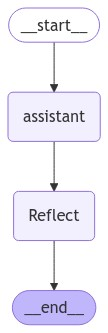

In [234]:
# Inner loop workflow
builder = StateGraph(Innerloop)
builder.add_node("assistant", assistant)
builder.add_node("Reflect", reflect_agent)

builder.add_edge(START, "assistant")
builder.add_edge("assistant", "Reflect")
builder.add_edge("Reflect", END)

memory = MemorySaver()
sub_graph = builder.compile(checkpointer=memory) # This compilation is for testing purposes only
display(Image(sub_graph.get_graph(xray=1).draw_mermaid_png()))

In [244]:
sub_state = Innerloop(task="Add 2 and 3")
thread = {"configurable": {"thread_id": "1"}}
for event in sub_graph.stream(sub_state, thread, stream_mode="values"):
    print("Full Event:", event)

    # If event is a dictionary (which is common), you can print its keys and values
    if isinstance(event, dict):
        print("Event Keys:", event.keys())
        for key, value in event.items():
            print(f"{key}: {value}")

    # Optionally, if event has specific known attributes, you can print them like this:
    if 'messages' in event:
        for message in event['messages']:
            print("Message Content:", message['content'])

    # Print the last message or specific components
    # if 'messages' in event:
    #     event['messages'][-1].pretty_print()

Full Event: {'messages': [], 'task': 'Add 2 and 3', 'answer': AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_1s7c', 'function': {'arguments': '{"a": 2, "b": 3}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 673, 'total_tokens': 691, 'completion_time': 0.024, 'prompt_time': 0.175180069, 'queue_time': 0.002021569000000001, 'total_time': 0.199180069}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_9cb648b966', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-c6f2ffa4-c312-46cf-a4e3-5e06afc42139-0', tool_calls=[{'name': 'add', 'args': {'a': 2, 'b': 3}, 'id': 'call_1s7c', 'type': 'tool_call'}], usage_metadata={'input_tokens': 673, 'output_tokens': 18, 'total_tokens': 691})}
Event Keys: dict_keys(['messages', 'task', 'answer'])
messages: []
task: Add 2 and 3
answer: content='' additional_kwargs={'tool_calls': [{'id': 'call_1s7c', 'function': {'arguments': '{"a": 2, "b": 3}',

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Calling add function with 2 and 3
INFO:root:Tool returned 5


5
Full Event: {'messages': [], 'task': 'Add 2 and 3', 'answer': '5'}
Event Keys: dict_keys(['messages', 'task', 'answer'])
messages: []
task: Add 2 and 3
answer: 5


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Full Event: {'messages': [], 'task': 'Add 2 and 3', 'answer': AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_axay', 'function': {'arguments': '{"a": 2, "b": 3}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 673, 'total_tokens': 691, 'completion_time': 0.024, 'prompt_time': 0.137621705, 'queue_time': 0.002289041999999991, 'total_time': 0.161621705}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_9cb648b966', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-76808f69-eae9-4c90-a847-9bd2f2b4cfc1-0', tool_calls=[{'name': 'add', 'args': {'a': 2, 'b': 3}, 'id': 'call_axay', 'type': 'tool_call'}], usage_metadata={'input_tokens': 673, 'output_tokens': 18, 'total_tokens': 691})}
Event Keys: dict_keys(['messages', 'task', 'answer'])
messages: []
task: Add 2 and 3
answer: content='' additional_kwargs={'tool_calls': [{'id': 'call_axay', 'function': {'arguments': '{"a": 2, "b": 3}',

In [245]:
class OverallState(TypedDict):
    query: str
    tasks: List[str]
    answers: Annotated[list, operator.add]
    feedback: str
    ans: str
    

In [246]:
# Human Feedback
def human_feedback(state: OverallState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: OverallState):
    """ Return the next node to execute """

    user_feedback = input("Please provide feedback or 'Punch it!' Captain Pike! (I mean hit enter): ").strip()

    # If no feedback is provided, use "Punch It!" as default
    state.feedback = user_feedback if user_feedback else "Punch It!"

    # Check if feedback is not "Punch It!" to proceed
    if state.feedback != "Punch It!":
        return "plan_agent"
    
    # Otherwise end
    return "combine_answers"

In [247]:
def combine_answers(state: OverallState) -> str:
    """ Combine all the answers in the Dictionary & Generate a final comprehensive answer. """
    context = " ".join([v for v in state.answers if v])
    
    messages: List[AIMessage | HumanMessage | SystemMessage] = [
        SystemMessage(content="""
            You are an AI assistant. Your task is to provide a detailed, natural language answer 
            to the main query based on the given sub-answers.
        """),
        HumanMessage(content=f"""
            Here is the main query: "{state.query}".
            Below are some relevant sub-answers:
            {context}
            
            Please provide a detailed, natural language answer to the main query based on the sub-answers.
        """)
    ]
    # Get the LLM's response
    llm_response = llm.invoke(messages)
    
    # Assuming llm() returns a string. If it returns a message object, you might need to extract the content.
    if isinstance(llm_response, AIMessage):
        final_answer = llm_response.content
    else:
        final_answer = llm_response
    
    # Store the final answer in the state
    state.ans = final_answer
    return final_answer

In [248]:
def parallelize( state: OverallState):
    return [Send("solve", {"task": task,
                             "messages": [HumanMessage(content=f"solve the task {task}")], "innerloop.task": task}) for task in state.tasks]

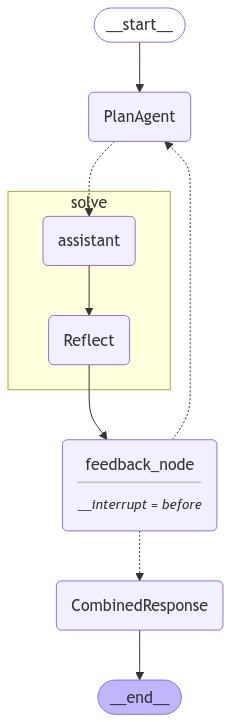

In [249]:
workflow = StateGraph(OverallState)
workflow.add_node("PlanAgent", plan_agent)
workflow.add_node("solve", builder.compile())
workflow.add_node("feedback_node", human_feedback)
# workflow.add_node("should_continue", should_continue)
workflow.add_node("CombinedResponse", combine_answers)

workflow.add_edge(START, "PlanAgent")
# workflow.add_edge("PlanAgent", "solve")
workflow.add_conditional_edges("PlanAgent", parallelize, ["solve"])
workflow.add_edge("solve", "feedback_node")
workflow.add_conditional_edges("feedback_node", should_continue, ["PlanAgent", "CombinedResponse"])
workflow.add_edge("CombinedResponse", END)

graph = workflow.compile(interrupt_before=['feedback_node'], checkpointer=MemorySaver())
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [250]:
# query = "evalute 2+3, 4*7 & 5/0?"
query = "add 2 and 3, multiply 4 and 6, and divide 6 by 2 and return mean of all the answers"

# Pass the extracted content (a string) to the AgentState
# agent_state = AgentState(query=query)
thread = {"configurable": {"thread_id": "1"}}


for event in graph.stream(
    {"query": query},
    thread,
    stream_mode="values",
):
    # Print the entire event object for inspection
    print("Full Event:", event)

    # If event is a dictionary (which is common), you can print its keys and values
    if isinstance(event, dict):
        print("Event Keys:", event.keys())
        for key, value in event.items():
            print(f"{key}: {value}")

    # Optionally, if event has specific known attributes, you can print them like this:
    if 'messages' in event:
        for message in event['messages']:
            print("Message Content:", message['content'])

    # Print the last message or specific components
    if 'messages' in event:
        event['messages'][-1].pretty_print()


Full Event: {'query': 'add 2 and 3, multiply 4 and 6, and divide 6 by 2 and return mean of all the answers', 'answers': []}
Event Keys: dict_keys(['query', 'answers'])
query: add 2 and 3, multiply 4 and 6, and divide 6 by 2 and return mean of all the answers
answers: []


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Full Event: {'query': 'add 2 and 3, multiply 4 and 6, and divide 6 by 2 and return mean of all the answers', 'tasks': ['add 2 and 3 and return the result', 'multiply 4 and 6 and return the result', 'divide 6 by 2 and return the result', 'calculate the mean of the previous results and return the result'], 'answers': []}
Event Keys: dict_keys(['query', 'tasks', 'answers'])
query: add 2 and 3, multiply 4 and 6, and divide 6 by 2 and return mean of all the answers
tasks: ['add 2 and 3 and return the result', 'multiply 4 and 6 and return the result', 'divide 6 by 2 and return the result', 'calculate the mean of the previous results and return the result']
answers: []


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


24


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Calling add function with 2 and 3
INFO:root:Tool returned 5


3.0
5


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Calling add function with 10 and 20
INFO:root:Calling add function with 30 and 40
INFO:root:Calling add function with 10 and 20
INFO:root:Calling add function with 30 and 40
INFO:root:Tool returned 30
INFO:root:Calling add function with 10 and 20
INFO:root:Calling add function with 30 and 40
INFO:root:Calling add fun

30


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


InvalidUpdateError: At key 'answer': Can receive only one value per step. Use an Annotated key to handle multiple values.